<a href="https://colab.research.google.com/github/maderix/pytorch-notebooks/blob/main/01_pytorch_mnist_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

We'll create a simple Net to solve the MNIST task using colvolution layers.
The network takes 28x28 size image and returns 10 output indicating the probablities of each digit from 0-9

In [3]:
class MNISTNet(nn.Module):
  def __init__(self):
    super(MNISTNet,self).__init__()
    # First 2D convolutional layer, taking in 1 input channel (image),
    # outputting 32 convolutional features, with a square kernel size of 3
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    # Second 2D convolutional layer, taking in the 32 input layers,
    # outputting 64 convolutional features, with a square kernel size of 3
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    # we'll have dropout after conv layers for to prevent overfitting
    # we can use a batch normalization but we'll skip it for now
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout(0.5)
    #fully connected layers for categorizing the image features
    self.fc1 = nn.Linear(64*12*12, 128)
    self.fc2 = nn.Linear(128, 10)
  #forward function will determine how data passes through our model
  def forward(self, x):
    x = self.conv1(x)
    #use the relu activation
    x = F.relu(x)
    #second block
    x = self.conv2(x)
    x = F.relu(x)
    #create a maxpooling layer to reduce the compute requirements
    x = F.max_pool2d(x , 2)
    # pass data through the dropouts
    x = self.dropout1(x)
    #flatten the data so that it can pass through fc layers
    x = torch.flatten(x,1)
    #fully connected/dense block.
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    #print(x.shape)
    #we'll apply softmax to the final output to get nice probabilities for each digit
    output = F.softmax(x,dim=1)
    return output
    
mnet = MNISTNet()
print(mnet)


MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#Alternative network
Below is a 2nd network which doesn't use convolution layers, instead just uses fully connected layers. Since MNIST images are fairly small 28x28x1, a fully connected network is also viable for such a task.

In [4]:
class MNISTNet2(nn.Module):
  def __init__(self):
    super(MNISTNet2,self).__init__()
    
    self.fc1 = nn.Linear(784,128)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(128, 64)
    self.dropout2 = nn.Dropout(0.5)
    self.output = nn.Linear(64,10)
  #forward function will determine how data passes through our model
  def forward(self, x):
    x = x.view(-1,28*28)
    #use the relu activation
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    #second block
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    #print(x.shape)
    #we'll apply softmax to the final output to get nice probabilities for each digit
    output = F.log_softmax(self.output(x),dim=1)
    return output
    
mnet = MNISTNet2()
print(mnet)


MNISTNet2(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=64, out_features=10, bias=True)
)


# Random test
Let's do a random test to test the forward function of our net


In [5]:
random_data = torch.randn((1, 1, 28*28))
result = mnet(random_data)
print(result)

tensor([[-2.4151, -2.1324, -2.4195, -2.7665, -2.4342, -2.2825, -2.3004, -2.3487,
         -1.9704, -2.1590]], grad_fn=<LogSoftmaxBackward>)


# Training pipeline
Let's create a simple training pipeline by defining the optimizer and a loss function and setup the data pipeline


In [6]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


Transforms control in what format our data will be passed to the network. At minimum, we want to convert image data to floating point, preferably to (-1,+1) range and convert it to a Pytorch tensor

In [7]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                #transforms.Normalize(mean=0.5,std=0.5),
                                ])

In [8]:
mnist_trainset = datasets.MNIST(root='./data',train=True,download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data',train=False,download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


To load data efficiently, we'll use DataLoaders for train and test data

In [40]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.8214867 -0.42421296 tensor([1, 6, 8, 7, 6, 1, 8, 9, 3, 0, 8, 5, 4, 1, 9, 3, 9, 2, 8, 7, 6, 8, 1, 8,
        7, 1, 2, 4, 4, 5, 7, 7, 9, 3, 4, 5, 4, 1, 5, 8, 9, 2, 1, 8, 3, 6, 4, 2,
        9, 7, 1, 0, 6, 0, 0, 4, 4, 8, 8, 9, 9, 1, 8, 7])


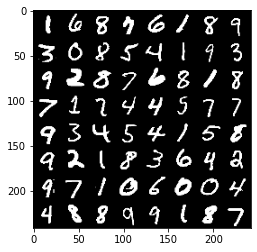

In [41]:
import matplotlib.pyplot as plt
import numpy as np
#let's test our dataloaders
images,labels = next(iter(train_loader))
print(np.max(images.numpy()),np.min(images.numpy()),labels)
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

In [49]:
import tqdm

net = MNISTNet()
learning_rate = 1e-2
epochs = 5
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Training
Let's build our training pipeline


1.   Get model output with current input
2.   Calculate loss
3.   Calculate gradients
4.   Update weights through optimizer

the 'to(device)' function will allow us to place the tensor on GPU if available.

In [50]:
net = net.to(device)
#zero out the gradients
for epoch in range(epochs):
  net.train()
  t = tqdm.tqdm(train_loader,leave=True, position=0)
  for images,labels in t:
    images = images.to(device)
    labels = labels.long().to(device)
    optimizer.zero_grad()
    output = net.forward(images)
    train_loss = criterion(output,labels)
    train_loss.backward()
    optimizer.step()
    t.set_description(f'epoch:{epoch+1} : train loss:{train_loss.item():.4f}')
    t.refresh()
  #evaluate after each epoch
  net.eval()
  images,labels = next(iter(test_loader))
  images = images.to(device)
  labels = labels.to(device)
  with torch.no_grad():
    output = net(images)
    valid_loss = criterion(output,labels)
    print(f'epoch:{epoch+1} : valid loss:{valid_loss.item():.4f}\n')

epoch:2 : train loss:1.6010:   1%|          | 6/938 [00:00<00:17, 53.06it/s]

epoch:1 : valid loss:1.5098



epoch:3 : train loss:1.5210:   1%|          | 6/938 [00:00<00:17, 52.90it/s]

epoch:2 : valid loss:1.4910



epoch:4 : train loss:1.5080:   1%|          | 5/938 [00:00<00:18, 49.66it/s]

epoch:3 : valid loss:1.4675



epoch:5 : train loss:1.4991:   1%|          | 6/938 [00:00<00:16, 56.21it/s]

epoch:4 : valid loss:1.4618



epoch:5 : train loss:1.4973: 100%|██████████| 938/938 [00:18<00:00, 51.93it/s]


epoch:5 : valid loss:1.4629



#Test and calculate accuracy

In [52]:
test_loss = 0
class_correct,class_total = [0]*10, [0] *10
#we'll load the weights from first network
net_eval=MNISTNet()
net_eval.load_state_dict(net.state_dict())
net_eval.eval()
#print([params for params in net.parameters()])
#plt.imshow(net_eval.state_dict()['fc1.weight'].detach().numpy(),cmap='gray')
#plt.imshow(net_eval.state_dict()['fc2.weight'].detach().numpy(),cmap='gray')
#plt.imshow(net_eval.state_dict()['output.weight'].detach().numpy(),cmap='gray')
for images,targets in test_loader:
  with torch.no_grad():
    output = net_eval(images)
    loss = criterion(output, targets)
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(targets.data.view_as(pred)))
    for i in range(len(targets)):
        label = targets.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')
print(f'Test accuracy: {np.sum(class_correct)/np.sum(class_total)*100} %')

Test Loss: 1.483486
Test accuracy: 97.81 %
